In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.patches as patches

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

In [2]:
billboard_hot_100.dtypes
plt.rcParams.update({'font.size': 15})

In [3]:
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959


In [4]:
from datetime import timedelta

grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)


In [5]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

## Position difference distributions

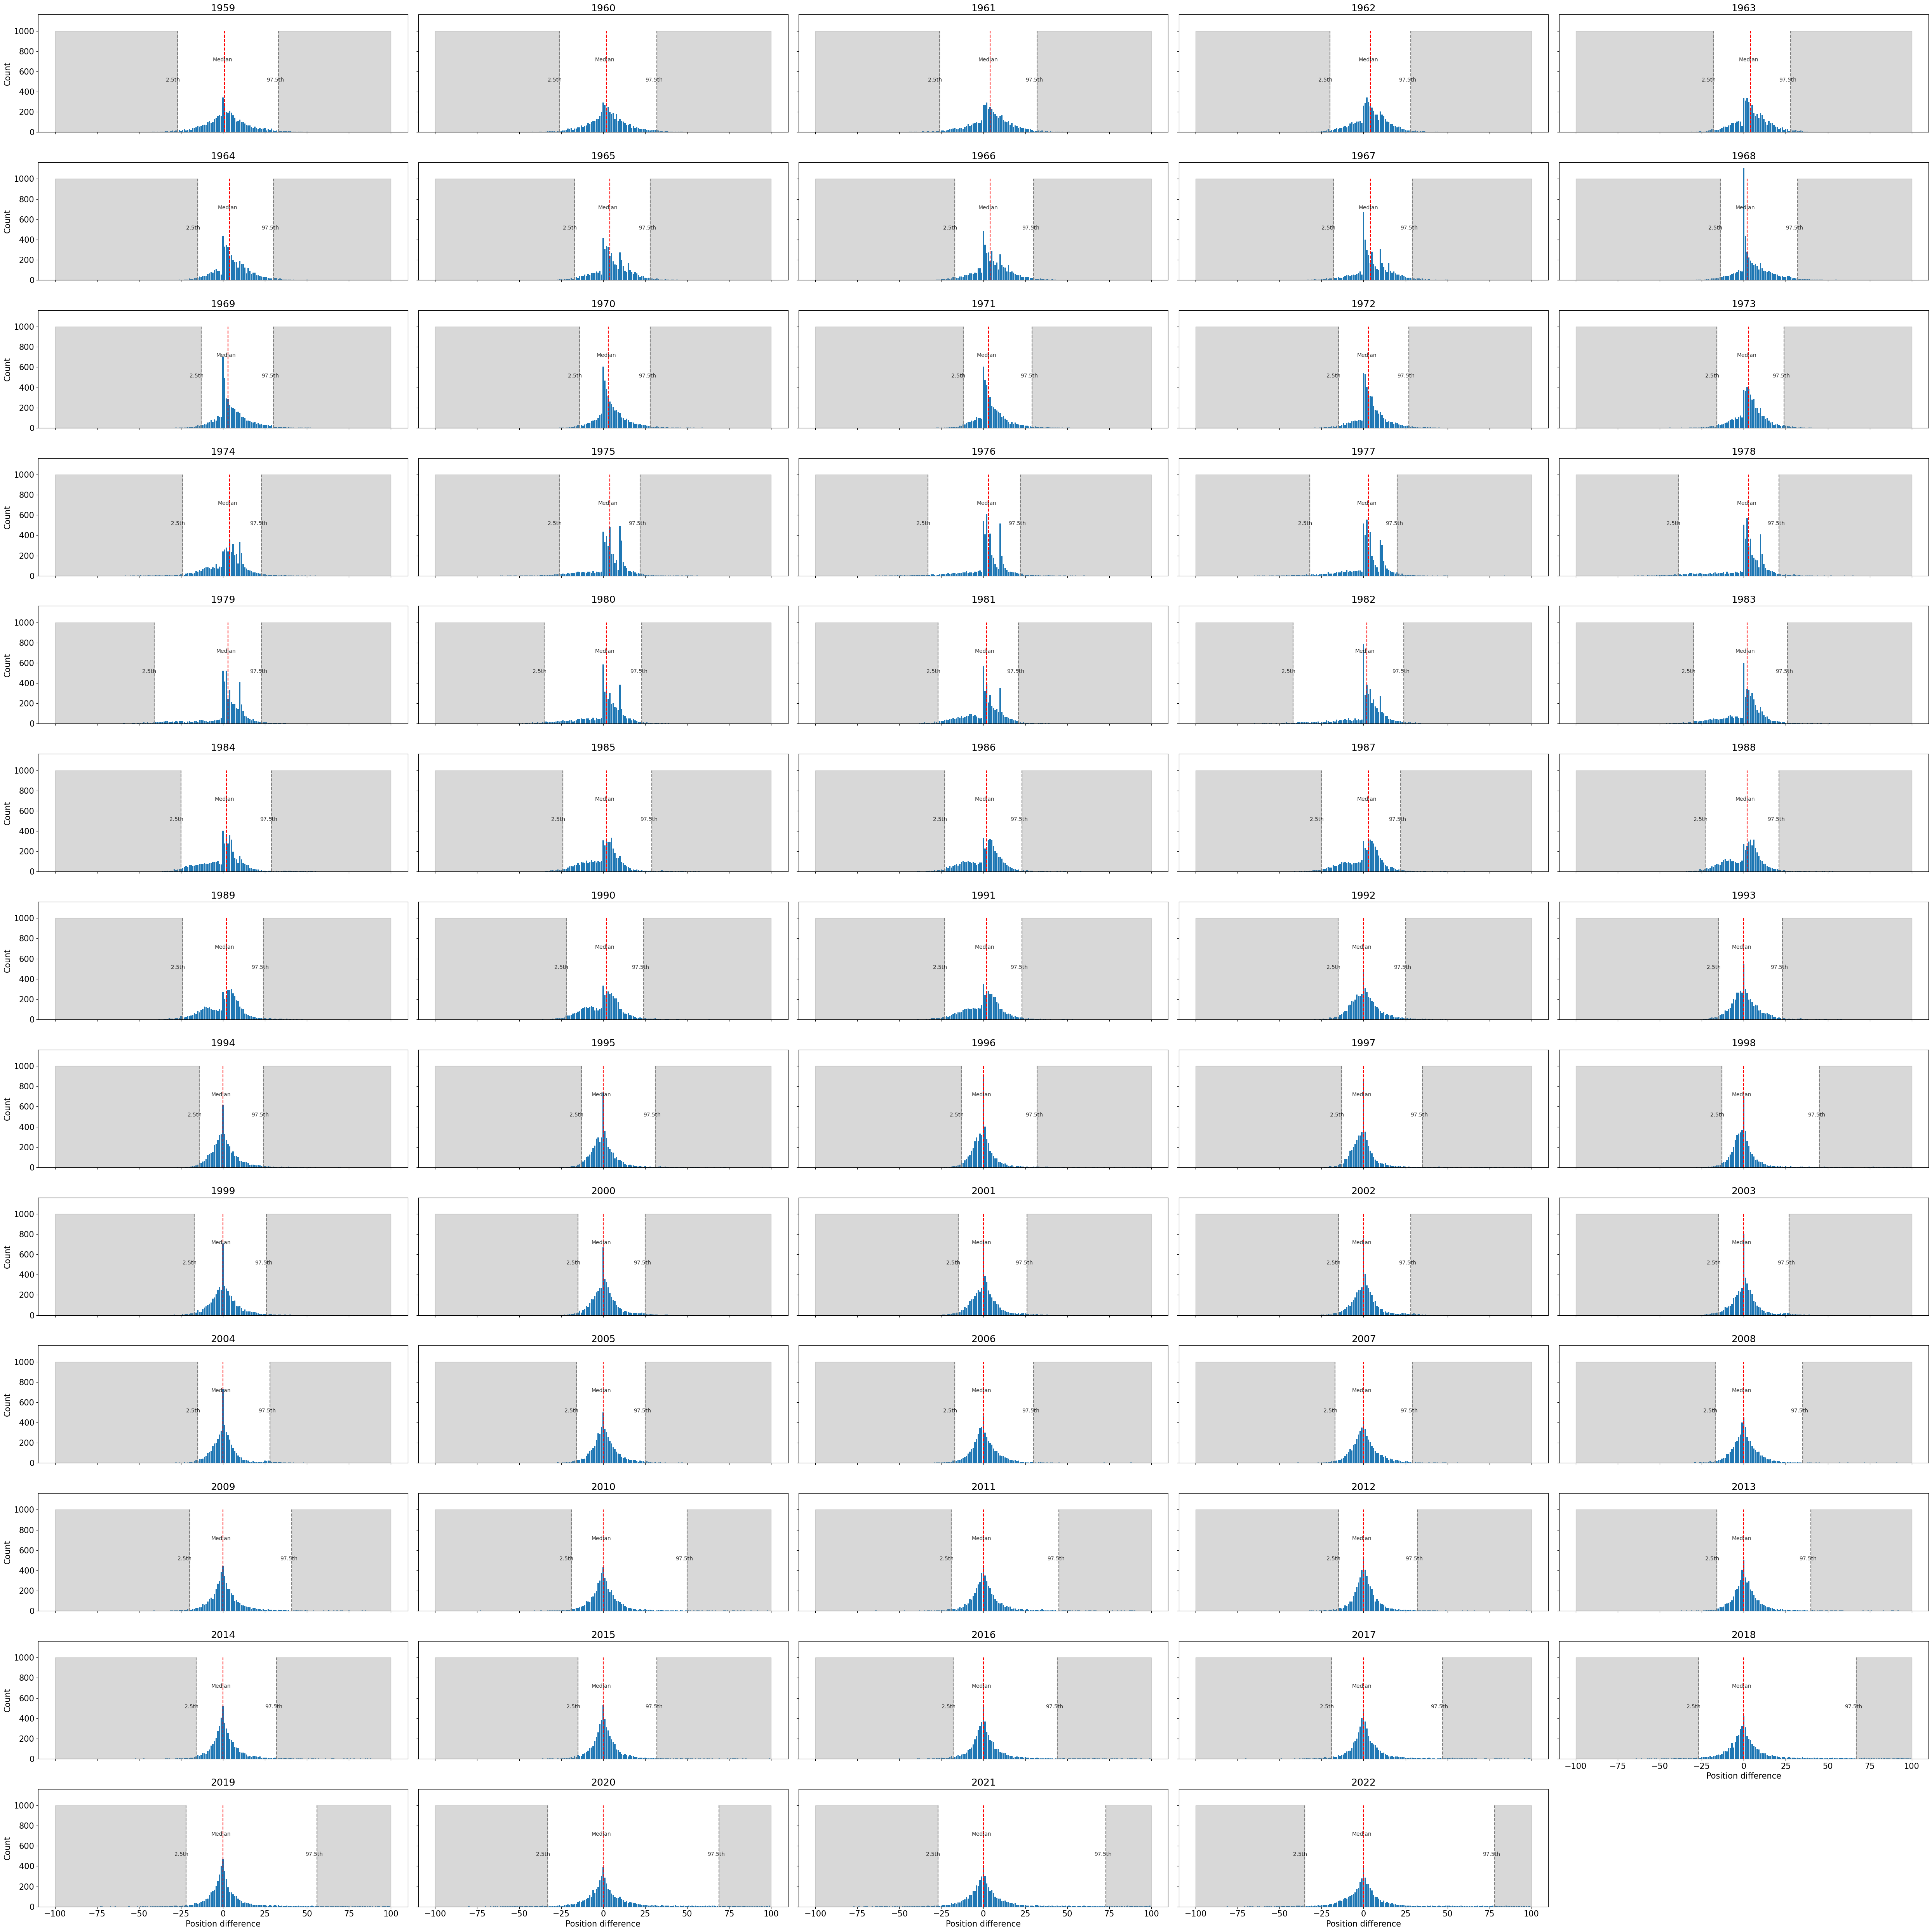

In [6]:
fig, axes = plt.subplots(13, 5, figsize=(50, 50), sharex=True, sharey=True)

row = 0
col = 0

distributions = {}
distributions_normalized = {}

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1959, 2023):
    year_subset = billboard_subset[billboard_subset["year"] == year]["position_change"]
    count_changes = year_subset.value_counts().sort_index()
    distributions[year] = count_changes

    # save normalized distribution
    distributions_normalized[year] = count_changes / count_changes.sum()
    axes[row, col].bar(count_changes.index, count_changes.values)
    perecentile_25 = year_subset.quantile(0.025)
    perecentile_975 = year_subset.quantile(0.975)
    perecentile_50 = year_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=1000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=1000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=1000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 1000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 500, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 1000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 500, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 - 7, 700, "Median", size = 10, alpha = 0.8)

    if row == 12 or ((row == 11) & (col == 4)):
        axes[row, col].set_xlabel("Position difference")
        axes[row, col].xaxis.set_tick_params(labelbottom=True)
        axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    if col == 0:
        axes[row, col].set_ylabel("Count")
    axes[row, col].set_title(f"{year}")
    col += 1
    if col == 5:
        col = 0
        row += 1

plt.delaxes(axes[12, 4])
plt.tight_layout()
plt.savefig("figures/position_difference_distribution_percentiles.pdf", format="pdf")
plt.show()

## Distances between probability distributions

### Calculating the Bhattacharyya distance between each pair of distributions https://en.wikipedia.org/wiki/Bhattacharyya_distance

In [7]:
def bhattacharyya_distance(distribution1, distribution2):
    return -math.log(sum(math.sqrt(x * y) for x, y in zip(distribution1, distribution2)))

In [8]:
distances_bhattacharyya = {}

for year_1 in range(1959, 2023):
    for year_2 in range(1959, 2023):
        if year_1 not in distances_bhattacharyya:
            distances_bhattacharyya[year_1] = {}
        distances_bhattacharyya[year_1][year_2] = bhattacharyya_distance(
            distributions_normalized[year_1].values, distributions_normalized[year_2].values)

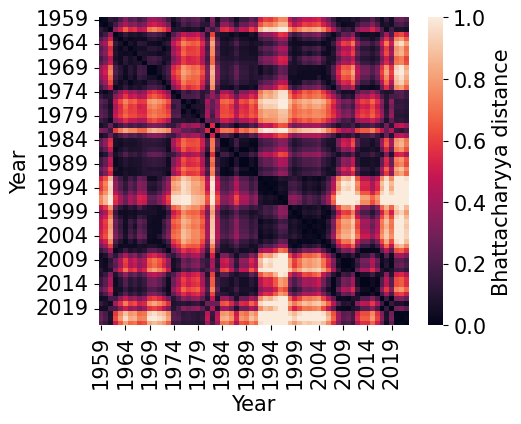

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(pd.DataFrame.from_dict(distances_bhattacharyya), ax=ax, vmax=1, 
                             cbar_kws={'label': 'Bhattacharyya distance'})
ax.set_xlabel("Year")
ax.set_ylabel("Year")

plt.savefig("figures/distances_distributions_bhattacharyya.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Calculating the Kullback–Leibler divergence between each pair of distributions https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

In [10]:
def kullback_leibler_distance(distribution1, distribution2):
    return sum(x * math.log(x / y) for x, y in zip(distribution1, distribution2))

In [11]:
# can be construed as measuring the expected number of extra bits
# required to code samples from P using a code optimized for Q rather than the
# code optimized for P

In [12]:
distances_kullback = {}

for year_1 in range(1959, 2023):
    for year_2 in range(1959, 2023):
        if year_1 not in distances_kullback:
            distances_kullback[year_1] = {}
        distances_kullback[year_1][year_2] = kullback_leibler_distance(
            distributions_normalized[year_1].values, distributions_normalized[year_2].values)

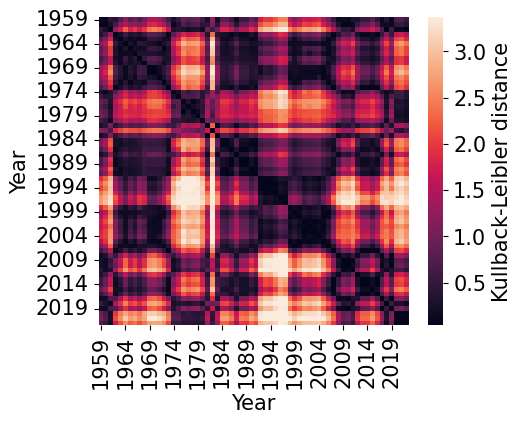

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(pd.DataFrame.from_dict(distances_kullback), ax=ax, robust=True, 
                             cbar_kws={'label': 'Kullback-Leibler distance'})
ax.set_xlabel("Year")
ax.set_ylabel("Year")

plt.savefig("figures/distances_distributions_kullback.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Distributions symmetries

In [26]:
import statistics as stats

def pearson_first_skewness(distribution):
    return (distribution.mean() - stats.mode(distribution)) / distribution.std()

In [24]:
def pearson_second_skewness(distribution):
    return 3 * (distribution.mean() - np.median(distribution)) / distribution.std()

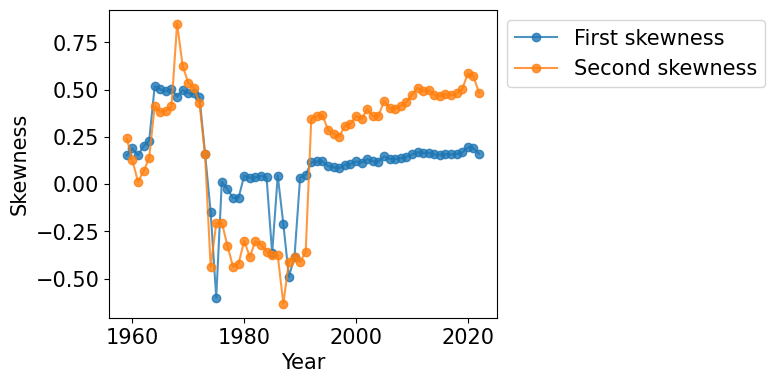

In [28]:
plt.figure(figsize=(5, 4))

first_skewness_distributions = []
second_skewness_distributions = []

for year in range(1959, 2023):
    year_subset = billboard_subset[billboard_subset["year"] == year]["position_change"]
    first_skewness = pearson_first_skewness(year_subset.values)
    first_skewness_distributions.append(first_skewness)

    second_skewness = pearson_second_skewness(year_subset.values)
    second_skewness_distributions.append(second_skewness)

plt.plot(range(1959, 2023), first_skewness_distributions, marker="o", alpha=0.8)
plt.plot(range(1959, 2023), second_skewness_distributions, marker="o", alpha=0.8)

plt.xlabel("Year")
plt.ylabel("Skewness")
plt.legend(["First skewness", "Second skewness"], bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig("figures/skewness_distribution.pdf", format="pdf", bbox_inches="tight")

### Fisher-Pearson coefficient of skewness

In [21]:
from scipy import stats

def fisher_skewness(distribution):    return stats.skew(distribution)

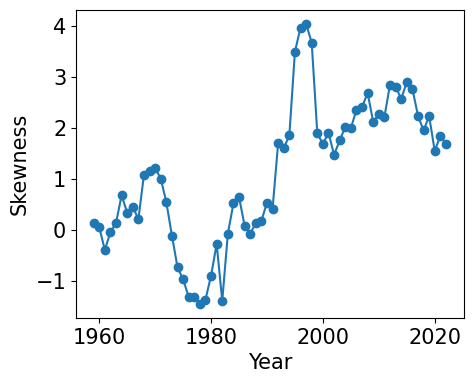

In [22]:
plt.figure(figsize=(5, 4))

fisher_skewness_distributions = []

for year in range(1959, 2023):
    year_subset = billboard_subset[billboard_subset["year"] == year]["position_change"]
    fisher_skweness = fisher_skewness(year_subset.values)
    fisher_skewness_distributions.append(fisher_skweness)

plt.plot(range(1959, 2023), fisher_skewness_distributions, marker="o")

plt.xlabel("Year")
plt.ylabel("Skewness")

plt.savefig("figures/fisher_skewness_distribution.pdf", format="pdf", bbox_inches="tight")